# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import lightgbm as lgb

# EDA

In [2]:
df_sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e9/sample_submission.csv')
df_train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv', index_col='id')

In [3]:
df_train.isna().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

##### There are no missing values in our train data.

In [4]:
df_sample_submission.head()

,id,Strength
0,5407,35.452
1,5408,35.452
2,5409,35.452
3,5410,35.452
4,5411,35.452


##### We are prediction strength for each id in the test set.

In [5]:
df_train.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


##### All features and target appear to be continuous and numerical.

In [6]:
df_train.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


##### It looks like there might be some outliers in SuperplasticizerComponent, and BlastFurnaceSlag. However, they most likely are true outliers due to the nature of the data.

<function matplotlib.pyplot.show(close=None, block=None)>

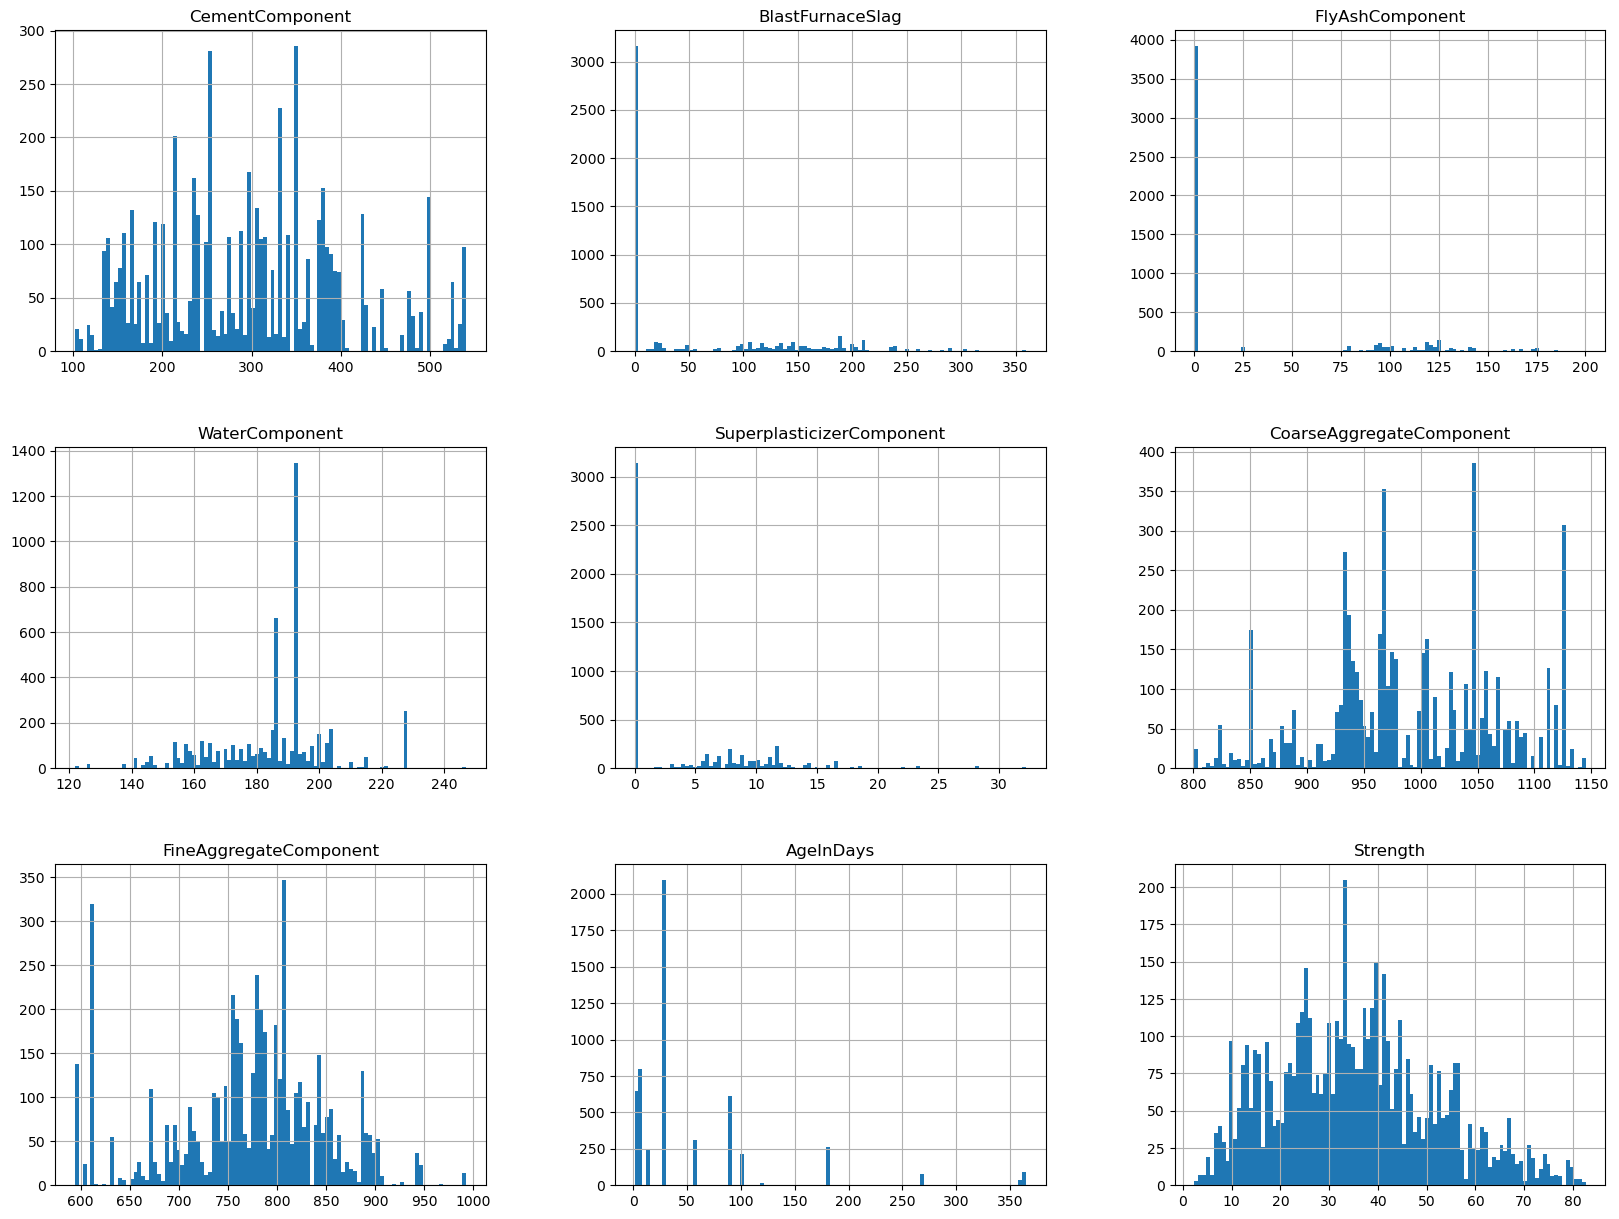

In [7]:
df_train.hist(bins=100, figsize=(20, 15))
plt.show

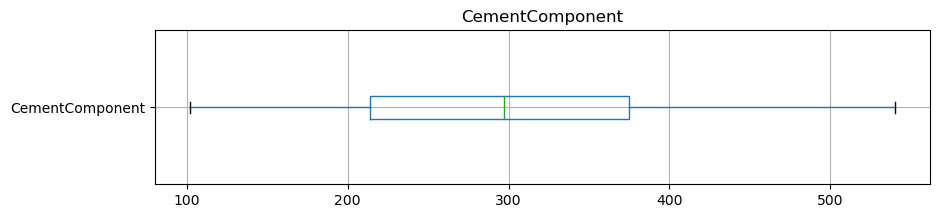

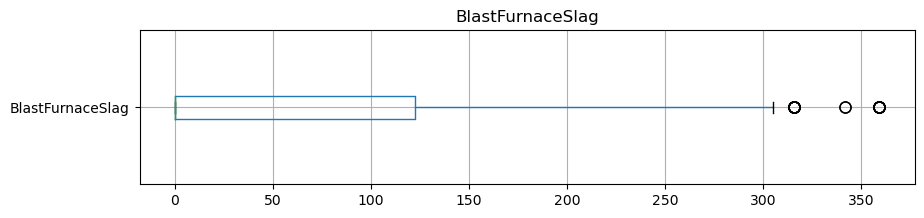

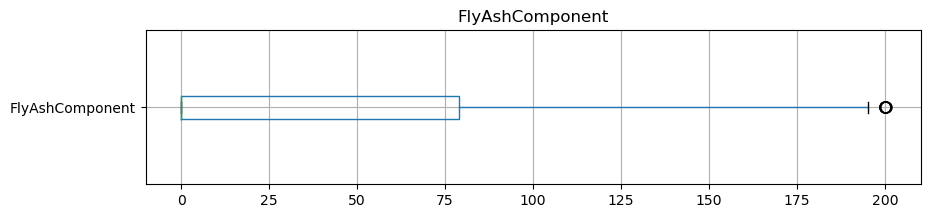

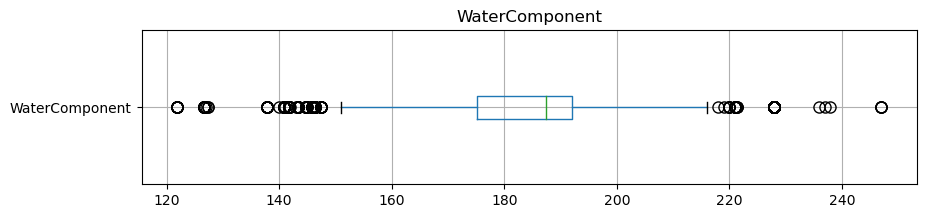

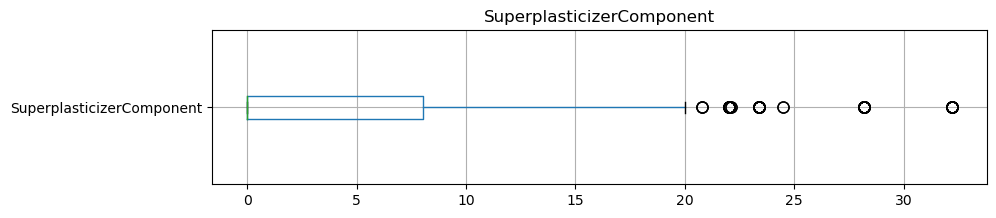

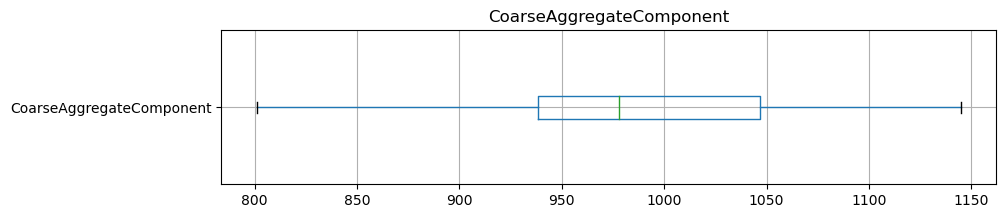

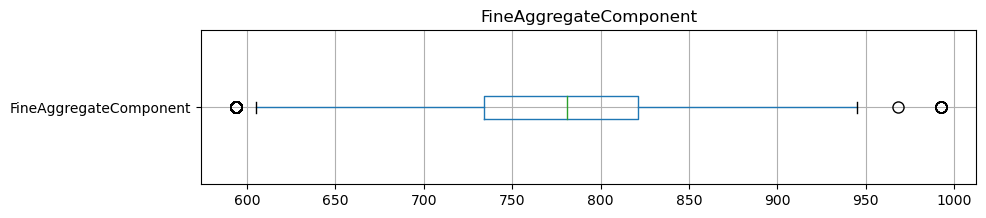

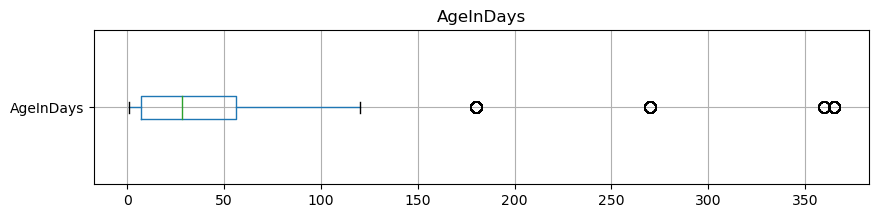

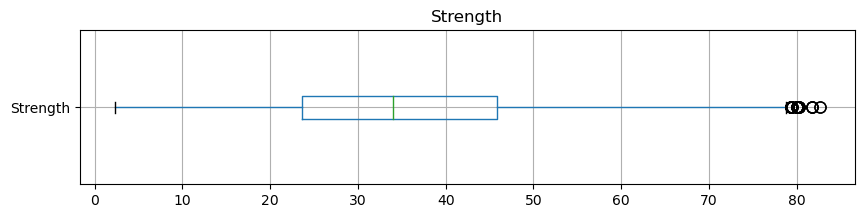

In [8]:
#df_train.boxplot(color='blue', vert=False, whis=0.75, flierprops=dict(marker='o', markersize=8))
for col in df_train.columns:
    fig = plt.figure(figsize=(10, 2))
    df_train.boxplot(column=[col], vert=False, flierprops=dict(marker='o', markersize=8))
    plt.title(col)
    plt.show()

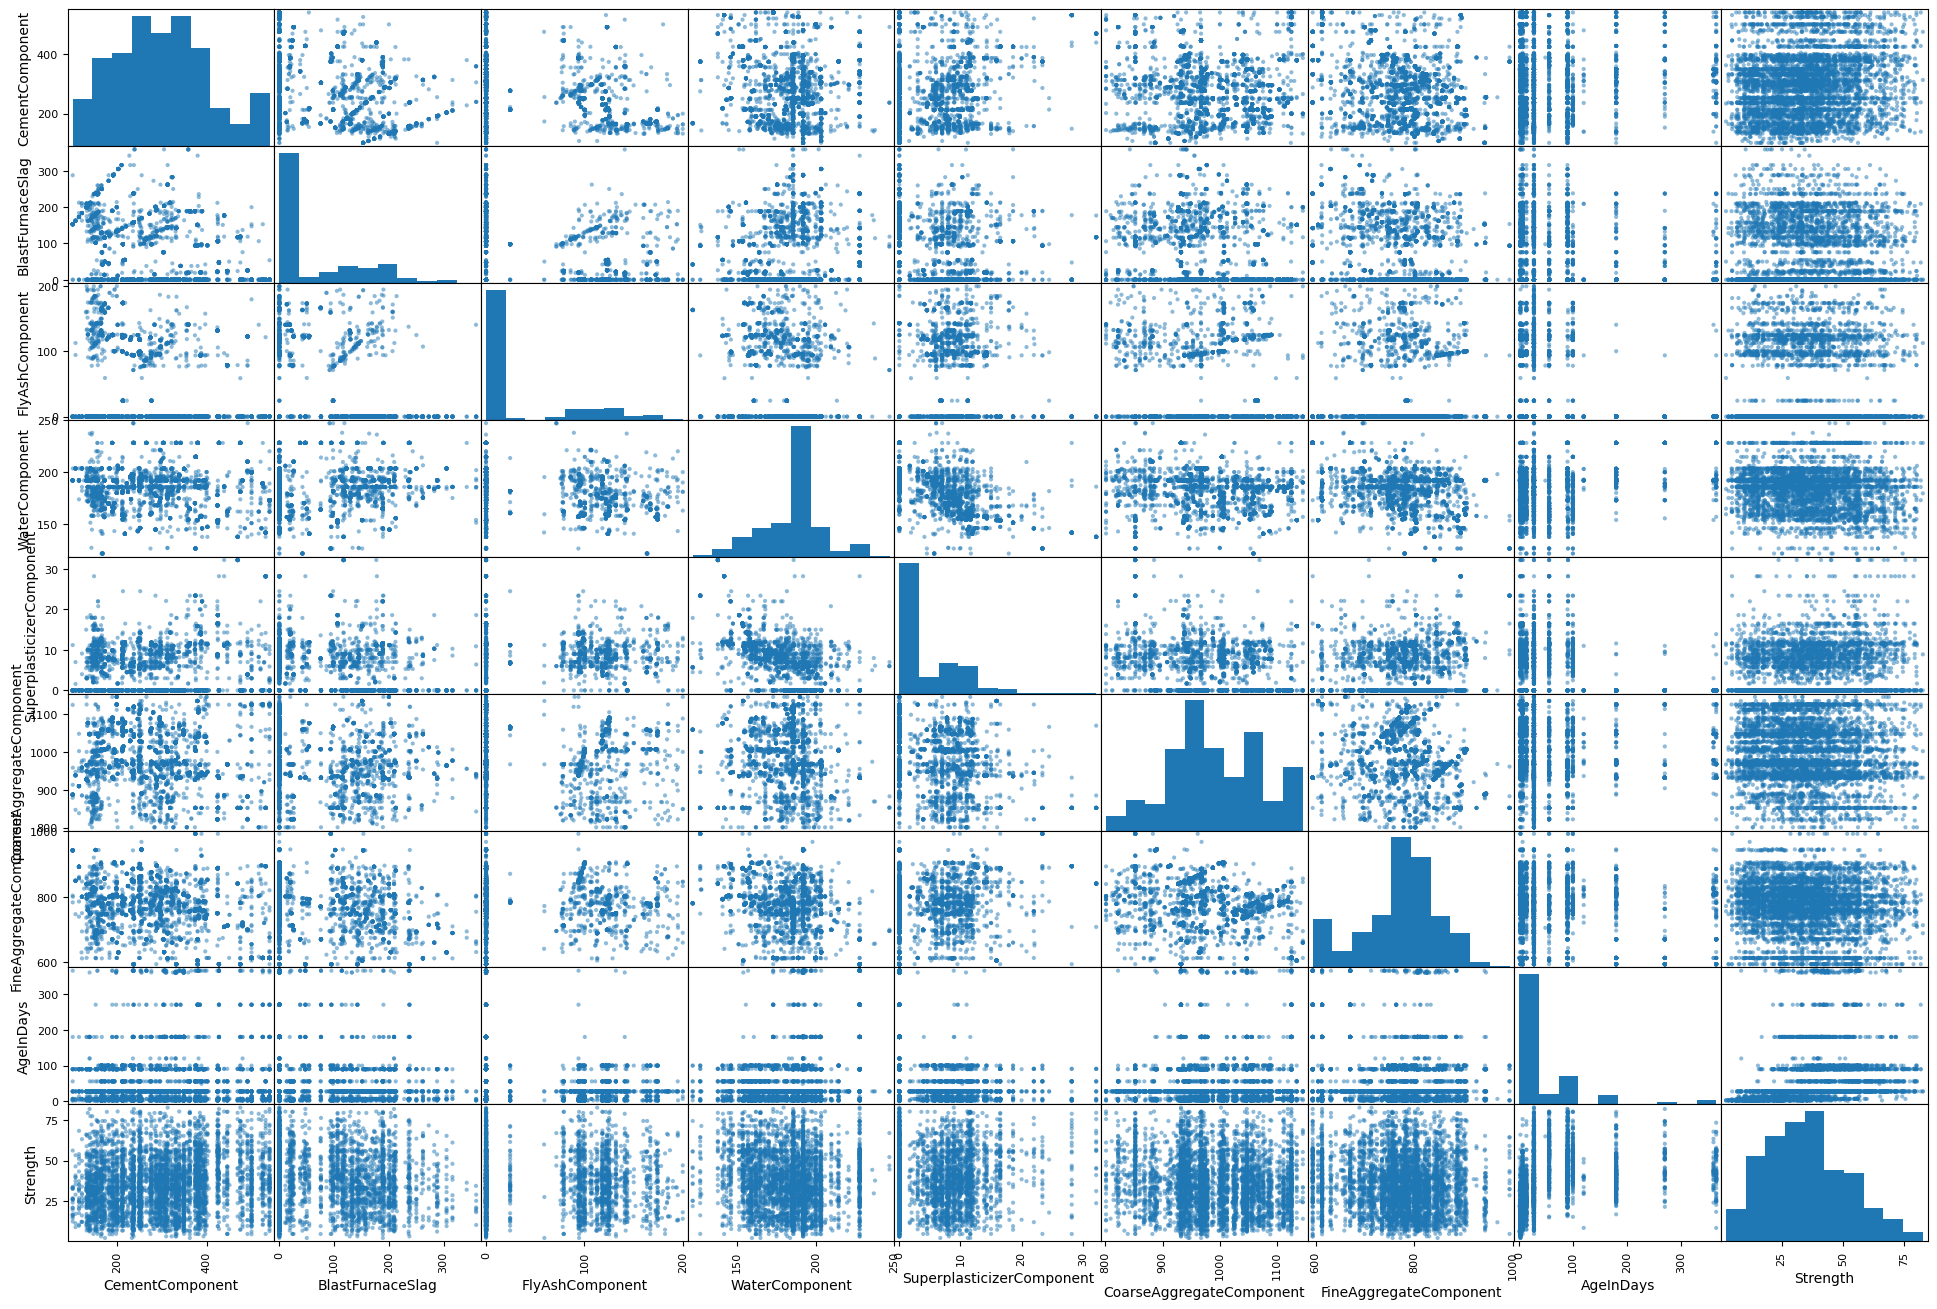

In [9]:
pd.plotting.scatter_matrix(df_train, figsize=(24, 16))
plt.show()

##### It looks like the are no basic relation between our features and the target.

In [10]:
def add_features(df):
    df['water-cement-ratio'] = df['CementComponent'] / df['WaterComponent']

In [11]:
add_features(df_train)

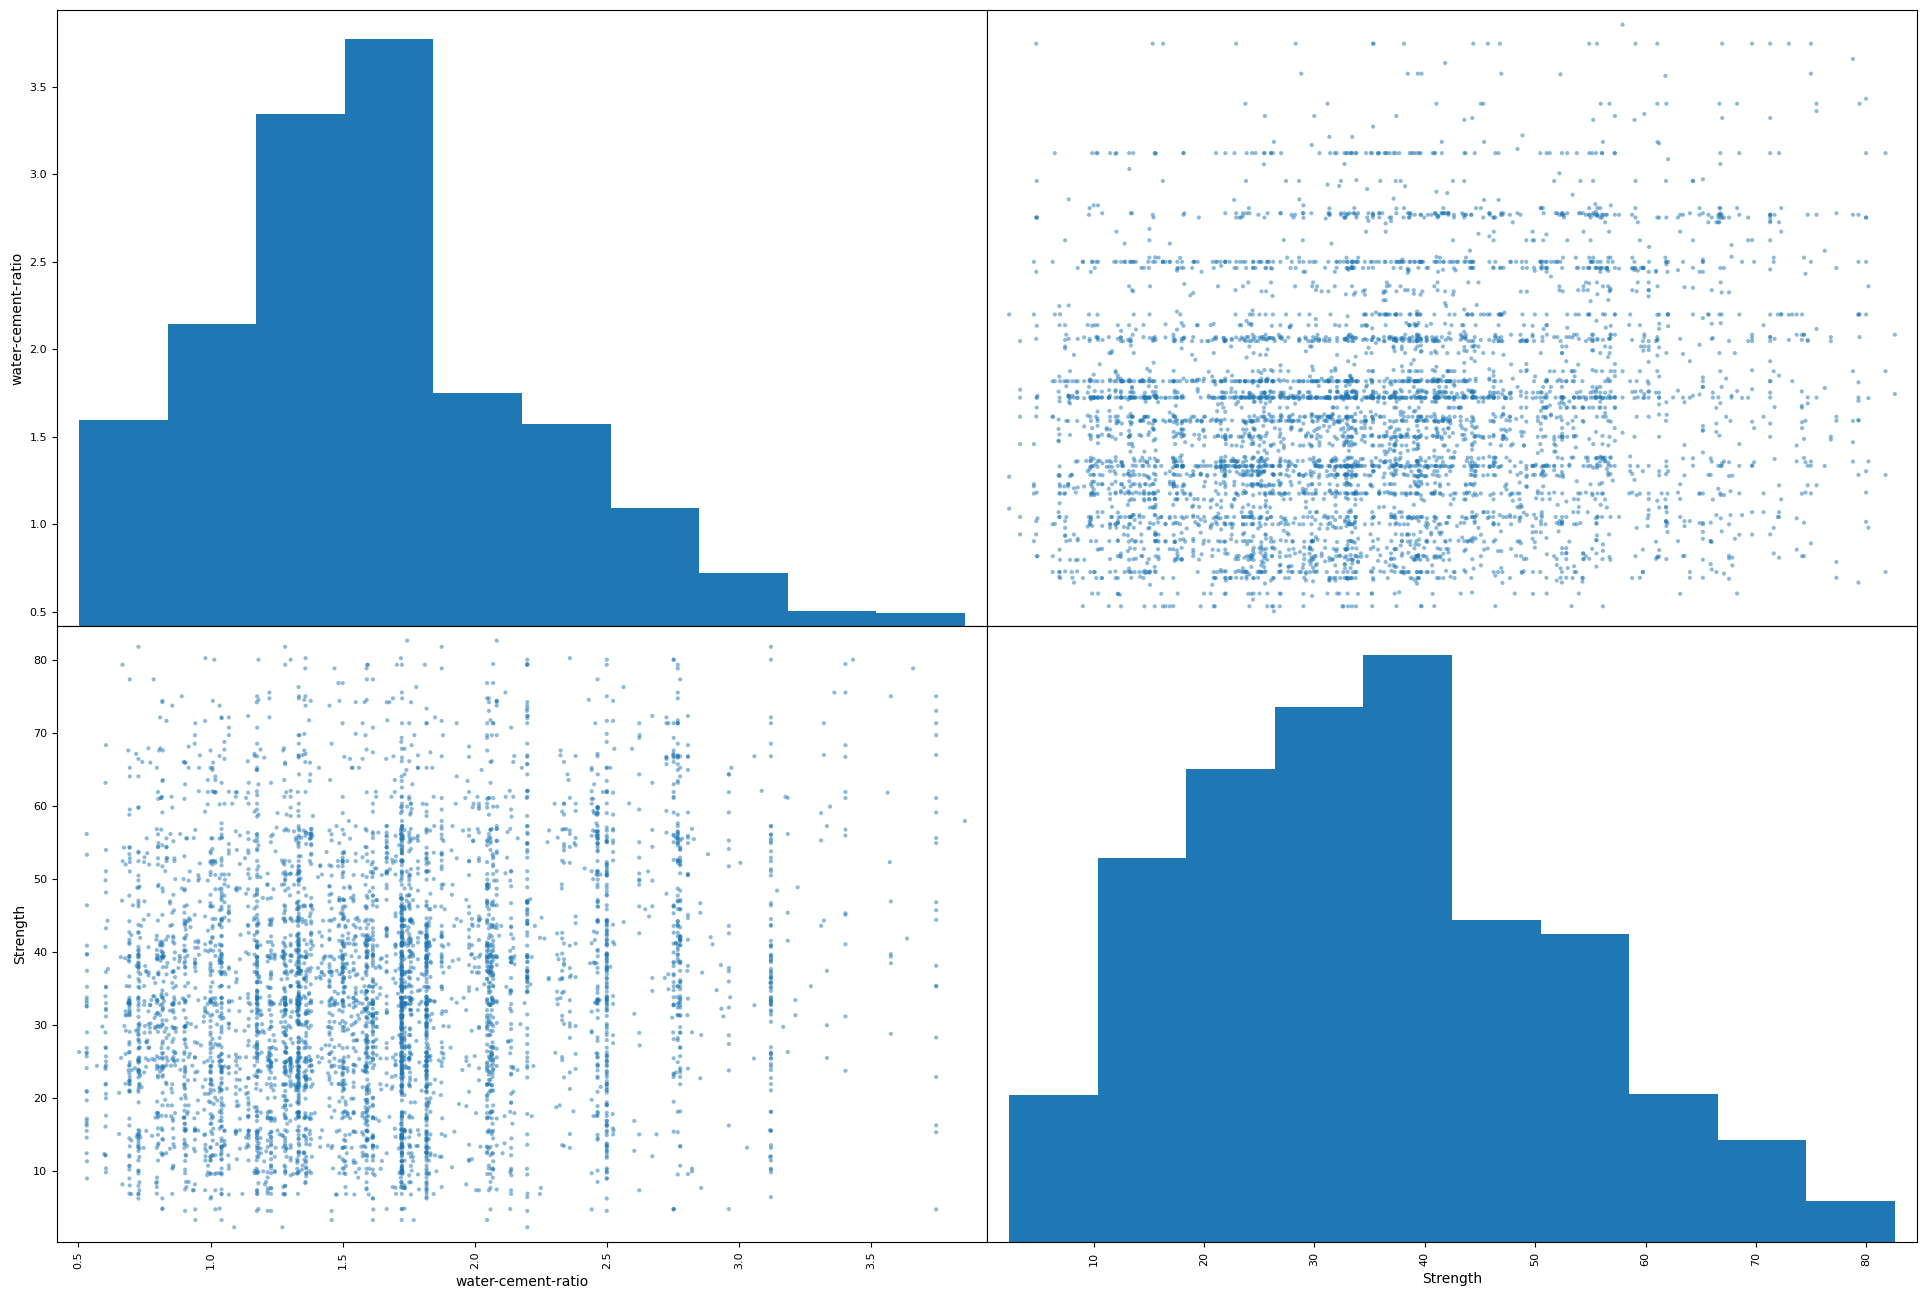

In [12]:
pd.plotting.scatter_matrix(df_train[['water-cement-ratio', 'Strength']], figsize=(24, 16))
plt.show()

##### Prevent any unwanted changes made in EDA from leaking to training

In [13]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv', index_col='id')

In [14]:
#add_features(df_train)
#add_features(df_test)

# Data Pipeline

In [15]:
class ConcretePipeline():
    
    def __init__(self, model='XGB', valid_sets=None):
        self.preprocessor = ColumnTransformer([ 
            ("num", StandardScaler(), df_train.drop('Strength', axis=1).columns.tolist()), 
        ])
        self.model_type = model
        if model == 'LGB':
            self.model = lgb.LGBMRegressor(
                                            num_leaves = 16,
                                            learning_rate = 0.01,
                                            early_stopping_rounds = 100,
                                            n_estimators=2000,
                                            objective = "regression",
                                            metric = "rmse")
        elif model == 'CatBoost':
            self.model = CatBoostRegressor(
                iterations=10000,
                learning_rate=0.0005, 
                depth=5, 
                l2_leaf_reg=3,
                loss_function='RMSE')
        else:
            self.model = xgb.XGBRegressor(n_estimators = 1000, 
                                          learning_rate = 0.01, 
                                          max_depth = 3, 
                                          colsample_bytree = 0.7, 
                                          objective='reg:squarederror',
                                          gamma = 0.8, 
                                          min_child_weight = 10, 
                                          subsample = 0.7
                                         )
        self.target_preprocessor = StandardScaler()
        
    def fit(self, X, y, X_eval, y_eval):
        X = self.preprocessor.fit_transform(X)
        X_val = self.preprocessor.transform(X_eval)
        
        y = self.target_preprocessor.fit_transform(y.to_numpy().reshape(-1, 1))
        y_val = self.target_preprocessor.transform(y_eval.to_numpy().reshape(-1, 1))
        
        self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)
        
    def predict(self, X):
        X = self.preprocessor.transform(X)
        y_pred = self.model.predict(X)
        y_pred = self.target_preprocessor.inverse_transform(y_pred.reshape(-1, 1))
        return y_pred
    
    def grid_search(self, X, y, X_eval, y_eval):
        # Processes the data
        X = self.preprocessor.fit_transform(X)
        X_val = self.preprocessor.transform(X_eval)
    
        y = self.target_preprocessor.fit_transform(y.to_numpy().reshape(-1, 1))
        y_val = self.target_preprocessor.transform(y_eval.to_numpy().reshape(-1, 1))
        
        # Define the hyperparameters and their possible values
        param_grid = {
            'n_estimators': [10, 100, 1000, 5000],
            'max_depth': [3, 7, 11],
            'learning_rate':[0.1, 0.2], 
            'subsample': [1, 10],
            'reg_lambda': [0, 1, 2],
            'reg_alpha': [0, 1, 2],
            'objective':['reg:squarederror'],
            'early_stopping_rounds':[5],
            'tree_method':["gpu_hist"]
        }

        # Create an XGBoost model and wrap it in a GridSearchCV object
        xgb_model = xgb.XGBRegressor()
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

        # Train the GridSearchCV object with early stopping
        grid_search.fit(X, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        print(grid_search.best_params_)

# Hyperparamiter search

In [16]:
#X = df_train.drop('Strength', axis=1)
#y = df_train['Strength']
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
#CustomePipeline().grid_search(X_train, y_train, X_val, y_val)

# Train the model

In [17]:
def train(model_type):
    X = df_train.drop(['Strength'], axis=1)
    y = df_train['Strength']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        # splits data to dev/train sets and removes outliers from train data
        train_dataframe = df_train.iloc[idx_tr]
        # it appears that removing outliers drasticly hurt the models accrecy,
        # i will have the review the this topic
        #train_dataframe = remove_outliers(train_dataframe)
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('Strength', axis=1)
        y_train = train_dataframe['Strength']
        X_dev = dev_dataframe.drop('Strength', axis=1)
        y_dev = dev_dataframe['Strength']

        # crates and fits a pipeline
        pipelineMy = ConcretePipeline(model=model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_squared_error(y_dev, pipelineMy.predict(X_dev), squared=False)
        losses.append(loss)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines

## XGBoost

In [18]:
losses, pipelines = train('XGB')

Fold 0 loss: 12.250643944636874
Fold 1 loss: 11.809841816807458
Fold 2 loss: 12.124912797258498
Fold 3 loss: 11.800480633393924
Fold 4 loss: 12.599213950159895
Mean loss: 12.11701862845133


## LGB

In [19]:
losses, pipelines = train('LGB')

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
Fold 0 loss: 12.320419342616598
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 loss: 11.843878059872601
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 12.162849797889889
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 11.81524048167047
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 12.576086884658848
Mean loss: 12.143694913341681


## CatBoost

In [20]:
losses, pipelines = train('CatBoost')

Fold 0 loss: 12.292997923487487
Fold 1 loss: 11.721756957160556
Fold 2 loss: 12.129069578102325
Fold 3 loss: 11.817570365992257
Fold 4 loss: 12.575825806965005
Mean loss: 12.107444126341527


# Feature Importance

In [21]:
#booster = pipelines[0].model.get_booster()
#importance_scores = booster.get_score(importance_type='weight')

# Plot feature importance
#fig, ax = plt.subplots()
#xgb.plot_importance(booster, importance_type='weight', ax=ax)
#ax.set_yticklabels(X.columns)
#plt.show()

# Make Submission

In [22]:
def make_predictions(pipelines, data):
    prediction = []
    for pipeline in pipelines:
        prediction.append(pipeline.predict(data))
    return np.array(prediction).mean(axis = 0).ravel()

In [23]:
finale_predictions = make_predictions(pipelines, df_test)

In [24]:
submissions = pd.DataFrame({"id": list(range(5407, 5407 + len(finale_predictions))), "Strength": finale_predictions})

In [25]:
pd.DataFrame(submissions).to_csv("submission.csv", index=False, header=True)